# Before your start:
- Read the README.md file
- Comment as much as you can and use the resources in the README.md file
- Happy learning!

In [2]:
# Import your libraries:

%matplotlib inline

import numpy as np
import pandas as pd

In this lab, we will explore a dataset that describes websites with different features and labels them either benign or malicious . We will use supervised learning algorithms to figure out what feature patterns malicious websites are likely to have and use our model to predict malicious websites.

# Challenge 1 - Explore The Dataset

Let's start by exploring the dataset. First load the data file:

In [3]:
websites = pd.read_csv('../data/website.csv')
websites.head()

,URL,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CHARSET,SERVER,CONTENT_LENGTH,WHOIS_COUNTRY,WHOIS_STATEPRO,WHOIS_REGDATE,WHOIS_UPDATED_DATE,...,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,Type
0,M0_109,16,7,iso-8859-1,nginx,263.0,None,None,10/10/2015 18:21,None,...,0,2,700,9,10,1153,832,9,2.0,1
1,B0_2314,16,6,UTF-8,Apache/2.4.10,15087.0,None,None,None,None,...,7,4,1230,17,19,1265,1230,17,0.0,0
2,B0_911,16,6,us-ascii,Microsoft-HTTPAPI/2.0,324.0,None,None,None,None,...,0,0,0,0,0,0,0,0,0.0,0
3,B0_113,17,6,ISO-8859-1,nginx,162.0,US,AK,7/10/1997 4:00,12/09/2013 0:45,...,22,3,3812,39,37,18784,4380,39,8.0,0
4,B0_403,17,6,UTF-8,None,124140.0,US,TX,12/05/1996 0:00,11/04/2017 0:00,...,2,5,4278,61,62,129889,4586,61,4.0,0


#### Explore the data from an bird's-eye view.

You should already been very familiar with the procedures now so we won't provide the instructions step by step. Reflect on what you did in the previous labs and explore the dataset.

Things you'll be looking for:

* What the dataset looks like?
* What are the data types?
* Which columns contain the features of the websites?
* Which column contains the feature we will predict? What is the code standing for benign vs malicious websites?
* Do we need to transform any of the columns from categorical to ordinal values? If so what are these columns?

Feel free to add additional cells for your explorations. Make sure to comment what you find out.

In [4]:
# Your code here

# What the dataset looks like?
print(websites.describe())
print(websites.shape)
print(websites.isna().sum())

# What are the data types?
print(websites.dtypes)


        URL_LENGTH  NUMBER_SPECIAL_CHARACTERS  CONTENT_LENGTH  \
count  1781.000000                1781.000000      969.000000   
mean     56.961258                  11.111735    11726.927761   
std      27.555586                   4.549896    36391.809051   
min      16.000000                   5.000000        0.000000   
25%      39.000000                   8.000000      324.000000   
50%      49.000000                  10.000000     1853.000000   
75%      68.000000                  13.000000    11323.000000   
max     249.000000                  43.000000   649263.000000   

       TCP_CONVERSATION_EXCHANGE  DIST_REMOTE_TCP_PORT   REMOTE_IPS  \
count                1781.000000           1781.000000  1781.000000   
mean                   16.261089              5.472768     3.060640   
std                    40.500975             21.807327     3.386975   
min                     0.000000              0.000000     0.000000   
25%                     0.000000              0.000000     

In [5]:
websites.WHOIS_COUNTRY.unique()

array(['None', 'US', 'SC', 'GB', 'UK', 'RU', 'AU', 'CA', 'PA', 'se', 'IN',
       'LU', 'TH', "[u'GB'; u'UK']", 'FR', 'NL', 'UG', 'JP', 'CN', 'SE',
       'SI', 'IL', 'ru', 'KY', 'AT', 'CZ', 'PH', 'BE', 'NO', 'TR', 'LV',
       'DE', 'ES', 'BR', 'us', 'KR', 'HK', 'UA', 'CH', 'United Kingdom',
       'BS', 'PK', 'IT', 'Cyprus', 'BY', 'AE', 'IE', 'UY', 'KG'],
      dtype=object)

In [9]:
# Which columns contain the features of the websites?
websites.columns

""'URL_LENGTH', 'NUMBER_SPECIAL_CHARACTERS', 'CHARSET', 'SERVER','CONTENT_LENGTH', 'WHOIS_COUNTRY', 'WHOIS_STATEPRO','TCP_CONVERSATION_EXCHANGE', 'DIST_REMOTE_TCP_PORT'""
    
# I am not that familiar with website structures, but I believe the above features could indicate 
# wether a webiste is benign or malicious.

('URL_LENGTH',
 'NUMBER_SPECIAL_CHARACTERS',
 'CHARSET',
 'SERVER',
 'CONTENT_LENGTH',
 'WHOIS_COUNTRY',
 'WHOIS_STATEPRO',
 'TCP_CONVERSATION_EXCHANGE',
 'DIST_REMOTE_TCP_PORT')

In [10]:
# Which column contains the feature we will predict? What is the code standing for benign vs malicious websites?
""'Variable: TYPE - Code Benign: 0, Code Malicious: 1'""

'Variable: TYPE - Code Benign: 0, Code Malicious: 1'

In [12]:
# Do we need to transform any of the columns from categorical to ordinal values? If so what are these columns?
""'CHARSET, WHOISCOUNTRY'""

'CHARSET, WHOISCOUNTRY'

In [15]:
websites.isnull().sum()

URL                            0
URL_LENGTH                     0
NUMBER_SPECIAL_CHARACTERS      0
CHARSET                        0
SERVER                         1
CONTENT_LENGTH               812
WHOIS_COUNTRY                  0
WHOIS_STATEPRO                 0
WHOIS_REGDATE                  0
WHOIS_UPDATED_DATE             0
TCP_CONVERSATION_EXCHANGE      0
DIST_REMOTE_TCP_PORT           0
REMOTE_IPS                     0
APP_BYTES                      0
SOURCE_APP_PACKETS             0
REMOTE_APP_PACKETS             0
SOURCE_APP_BYTES               0
REMOTE_APP_BYTES               0
APP_PACKETS                    0
DNS_QUERY_TIMES                1
Type                           0
dtype: int64

#### Next, evaluate if the columns in this dataset are strongly correlated.

In the Mushroom supervised learning lab we did recently, we mentioned we are concerned if our dataset has strongly correlated columns because if it is the case we need to choose certain ML algorithms instead of others. We need to evaluate this for our dataset now.

Luckily, most of the columns in this dataset are ordinal which makes things a lot easier for us. In the next cells below, evaluate the level of collinearity of the data.

We provide some general directions for you to consult in order to complete this step:

1. You will create a correlation matrix using the numeric columns in the dataset.

1. Create a heatmap using `seaborn` to visualize which columns have high collinearity.

1. Comment on which columns you might need to remove due to high collinearity.

In [30]:
# Your code here
websites.corr()

,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CONTENT_LENGTH,TCP_CONVERSATION_EXCHANGE,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,Type
URL_LENGTH,1.000000,0.917986,0.129745,-0.038407,-0.039839,-0.046367,-0.026446,-0.042264,-0.033779,-0.014857,-0.026686,-0.042264,-0.068582,0.162104
NUMBER_SPECIAL_CHARACTERS,0.917986,1.000000,0.214225,-0.037459,-0.042619,-0.047103,-0.023914,-0.040096,-0.030597,-0.014376,-0.024098,-0.040096,-0.050048,0.280897
CONTENT_LENGTH,0.129745,0.214225,1.000000,0.078451,-0.000381,0.004774,0.051202,0.074142,0.091077,0.100094,0.047595,0.074142,-0.045644,-0.090852
TCP_CONVERSATION_EXCHANGE,-0.038407,-0.037459,0.078451,1.000000,0.555188,0.331080,0.457320,0.997796,0.990848,0.865580,0.458702,0.997796,0.349832,-0.040202
DIST_REMOTE_TCP_PORT,-0.039839,-0.042619,-0.000381,0.555188,1.000000,0.210188,0.780238,0.558612,0.591188,0.313359,0.781212,0.558612,0.259942,-0.082925
REMOTE_IPS,-0.046367,-0.047103,0.004774,0.331080,0.210188,1.000000,0.023126,0.361104,0.304683,0.171651,0.025324,0.361104,0.548189,-0.078783
APP_BYTES,-0.026446,-0.023914,0.051202,0.457320,0.780238,0.023126,1.000000,0.445822,0.468999,0.074464,0.999992,0.445822,0.012221,-0.011262
SOURCE_APP_PACKETS,-0.042264,-0.040096,0.074142,0.997796,0.558612,0.361104,0.445822,1.000000,0.989285,0.857495,0.447448,1.000000,0.410843,-0.034414
REMOTE_APP_PACKETS,-0.033779,-0.030597,0.091077,0.990848,0.591188,0.304683,0.468999,0.989285,1.000000,0.880555,0.470401,0.989285,0.355716,-0.032897
SOURCE_APP_BYTES,-0.014857,-0.014376,0.100094,0.865580,0.313359,0.171651,0.074464,0.857495,0.880555,1.000000,0.075328,0.857495,0.215285,-0.043852


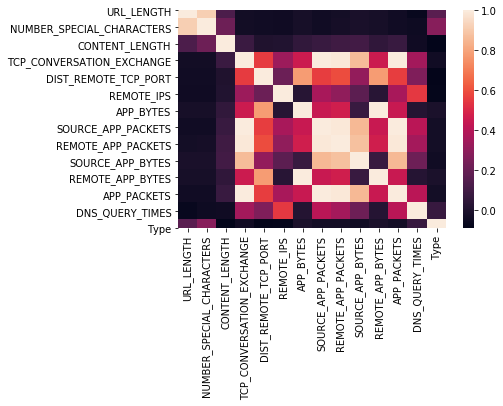

In [17]:
import seaborn as sns
sns.heatmap(websites.corr())

In [18]:
# Your comment here
""'URL Lenght and Number special characters are highly correlated, as well as App Packets with each 
'other and App Bytes and TCP Conversation exchange with the latter. '""

'URL Lenght and Number special characters are highly correlated, as well as App Packets with each other and App Bytes and TCP Conversation exchange '

# Challenge 2 - Remove Column Collinearity.

From the heatmap you created, you should have seen at least 3 columns that can be removed due to high collinearity. Remove these columns from the dataset.

Note that you should remove as few columns as you can. You don't have to remove all the columns at once. But instead, try removing one column, then produce the heatmap again to determine if additional columns should be removed. As long as the dataset no longer contains columns that are correlated for over 90%, you can stop. Also, keep in mind when two columns have high collinearity, you only need to remove one of them but not both.

In the cells below, remove as few columns as you can to eliminate the high collinearity in the dataset. Make sure to comment on your way so that the instructional team can learn about your thinking process which allows them to give feedback. At the end, print the heatmap again.

In [25]:
# Your code here
# Removing URL Length and Source APP Packets 

websites_dropped = websites.drop(['URL_LENGTH','SOURCE_APP_PACKETS'], axis=1)

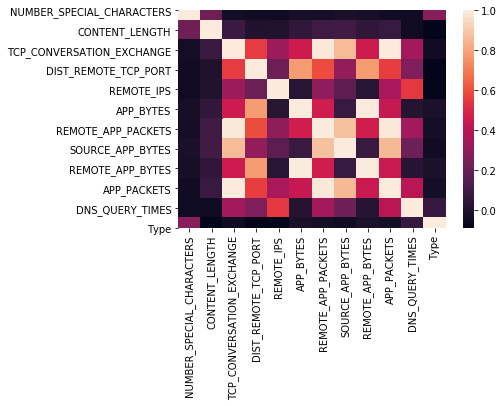

In [26]:
websites_dropped.corr()
sns.heatmap(websites_dropped.corr())

In [27]:
# Dropping also Remote APP Packets, TCP_Conversation exchange
websites_dropped = websites_dropped.drop(['REMOTE_APP_PACKETS','TCP_CONVERSATION_EXCHANGE'], axis=1)

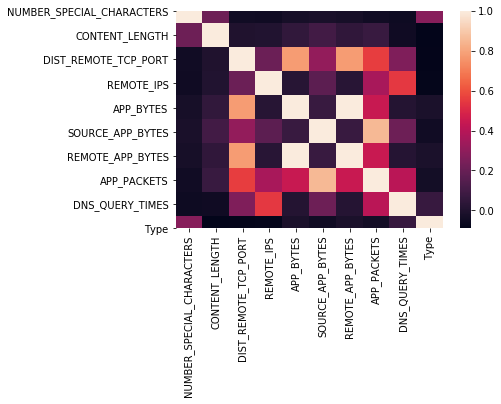

In [28]:
# Print heatmap again
websites_dropped.corr()
sns.heatmap(websites_dropped.corr())

In [29]:
# Dropping also Remote APP Bytes, Source App Bytes
websites_dropped = websites_dropped.drop(['REMOTE_APP_BYTES','SOURCE_APP_BYTES'], axis=1)

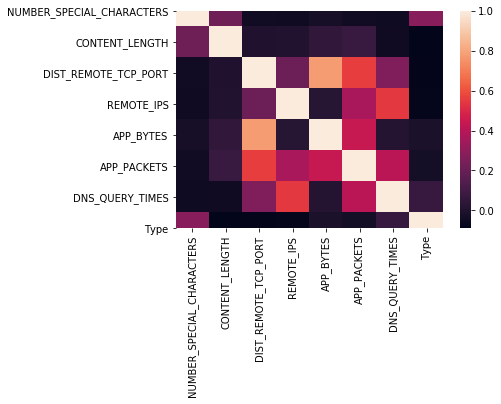

In [30]:
# Print heatmap again
websites_dropped.corr()
sns.heatmap(websites_dropped.corr())

# Challenge 3 - Handle Missing Values

The next step would be handling missing values. **We start by examining the number of missing values in each column, which you will do in the next cell.**

In [32]:
# Your code here
websites_dropped.isnull().sum()

URL                            0
NUMBER_SPECIAL_CHARACTERS      0
CHARSET                        0
SERVER                         1
CONTENT_LENGTH               812
WHOIS_COUNTRY                  0
WHOIS_STATEPRO                 0
WHOIS_REGDATE                  0
WHOIS_UPDATED_DATE             0
DIST_REMOTE_TCP_PORT           0
REMOTE_IPS                     0
APP_BYTES                      0
APP_PACKETS                    0
DNS_QUERY_TIMES                1
Type                           0
dtype: int64

If you remember in the previous labs, we drop a column if the column contains a high proportion of missing values. After dropping those problematic columns, we drop the rows with missing values.

#### In the cells below, handle the missing values from the dataset. Remember to comment the rationale of your decisions.

In [34]:
websites.shape

(1781, 21)

In [33]:
# Your code here
total = len(websites_dropped.CONTENT_LENGTH)
prop = 812/total
print(f"The proportion of missing values in Rating is: {round(prop, 2)}%")

The proportion of missing values in Rating is: 0.46%


In [12]:
# Your comment here
# The proportion of missing values is high, therefore we will drop the column content lenght

In [37]:
websites_dropped = websites_dropped.drop(['CONTENT_LENGTH'], axis=1)

In [42]:
# Next Step: drop rows with missing values:
missing = websites_dropped[(websites_dropped['DNS_QUERY_TIMES'].isnull()==True)]
missing

,URL,NUMBER_SPECIAL_CHARACTERS,CHARSET,SERVER,WHOIS_COUNTRY,WHOIS_STATEPRO,WHOIS_REGDATE,WHOIS_UPDATED_DATE,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,Type
1659,B0_772,15,UTF-8,Apache,CA,ON,14/12/2009 0:00,13/12/2016 0:00,2,2,276,4,NaN,0


In [47]:
websites_dropped = websites_dropped.dropna()

#### Again, examine the number of missing values in each column. 

If all cleaned, proceed. Otherwise, go back and do more cleaning.

In [50]:
# Examine missing values in each column
websites_dropped.isnull().sum()

URL                          0
NUMBER_SPECIAL_CHARACTERS    0
CHARSET                      0
SERVER                       0
WHOIS_COUNTRY                0
WHOIS_STATEPRO               0
WHOIS_REGDATE                0
WHOIS_UPDATED_DATE           0
DIST_REMOTE_TCP_PORT         0
REMOTE_IPS                   0
APP_BYTES                    0
APP_PACKETS                  0
DNS_QUERY_TIMES              0
Type                         0
dtype: int64

# Challenge 4 - Handle `WHOIS_*` Categorical Data

There are several categorical columns we need to handle. These columns are:

* `URL`
* `CHARSET`
* `SERVER`
* `WHOIS_COUNTRY`
* `WHOIS_STATEPRO`
* `WHOIS_REGDATE`
* `WHOIS_UPDATED_DATE`

How to handle string columns is always case by case. Let's start by working on `WHOIS_COUNTRY`. Your steps are:

1. List out the unique values of `WHOIS_COUNTRY`.
1. Consolidate the country values with consistent country codes. For example, the following values refer to the same country and should use consistent country code:
    * `CY` and `Cyprus`
    * `US` and `us`
    * `SE` and `se`
    * `GB`, `United Kingdom`, and `[u'GB'; u'UK']`

#### In the cells below, fix the country values as intructed above.

In [51]:
# Your code here
websites_dropped.WHOIS_COUNTRY.unique()

array(['None', 'US', 'SC', 'GB', 'UK', 'RU', 'AU', 'CA', 'PA', 'se', 'IN',
       'LU', 'TH', "[u'GB'; u'UK']", 'FR', 'NL', 'UG', 'JP', 'CN', 'SE',
       'SI', 'IL', 'ru', 'KY', 'AT', 'CZ', 'PH', 'BE', 'NO', 'TR', 'LV',
       'DE', 'ES', 'BR', 'us', 'KR', 'HK', 'UA', 'CH', 'United Kingdom',
       'BS', 'PK', 'IT', 'Cyprus', 'BY', 'AE', 'IE', 'UY', 'KG'],
      dtype=object)

In [102]:
websites_country = websites_dropped.replace({'Cyprus': 'CY', 'us': 'US','se':'SE','ru':'RU','United Kingdom':'GB'})

In [103]:
websites_country = websites_country.replace({"[u'GB'; u'UK']":'GB','UK':'GB'})

In [104]:
websites_country.WHOIS_COUNTRY.unique()

array(['None', 'US', 'SC', 'GB', 'RU', 'AU', 'CA', 'PA', 'SE', 'IN', 'LU',
       'TH', 'FR', 'NL', 'UG', 'JP', 'CN', 'SI', 'IL', 'KY', 'AT', 'CZ',
       'PH', 'BE', 'NO', 'TR', 'LV', 'DE', 'ES', 'BR', 'KR', 'HK', 'UA',
       'CH', 'BS', 'PK', 'IT', 'CY', 'BY', 'AE', 'IE', 'UY', 'KG'],
      dtype=object)

Since we have fixed the country values, can we convert this column to ordinal now?

Not yet. If you reflect on the previous labs how we handle categorical columns, you probably remember we ended up dropping a lot of those columns because there are too many unique values. Too many unique values in a column is not desirable in machine learning because it makes prediction inaccurate. But there are workarounds under certain conditions. One of the fixable conditions is:

#### If a limited number of values account for the majority of data, we can retain these top values and re-label all other rare values.

The `WHOIS_COUNTRY` column happens to be this case. You can verify it by print a bar chart of the `value_counts` in the next cell to verify:

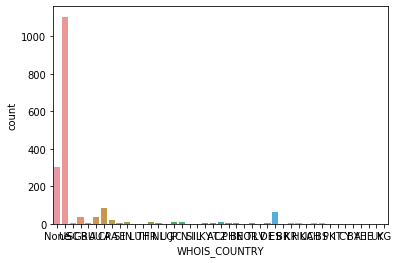

In [75]:
# Your code here
sns.countplot(websites_country.WHOIS_COUNTRY)

#### After verifying, now let's keep the top 10 values of the column and re-label other columns with `OTHER`.

In [93]:
websites_country.WHOIS_COUNTRY.value_counts()[:10]

US      1105
None     306
CA        83
ES        63
GB        35
AU        35
PA        21
JP        11
IN        10
CN        10
Name: WHOIS_COUNTRY, dtype: int64

In [83]:
lst_other = dict(websites_country.WHOIS_COUNTRY.value_counts()[10:])
lst_other

{'CZ': 9,
 'FR': 9,
 'RU': 6,
 'CH': 6,
 'NL': 6,
 'KR': 5,
 'AT': 4,
 'PH': 4,
 'SE': 4,
 'BS': 4,
 'BE': 3,
 'TR': 3,
 'DE': 3,
 'KY': 3,
 'HK': 3,
 'SC': 3,
 'NO': 2,
 'BR': 2,
 'IL': 2,
 'UY': 2,
 'UA': 2,
 'SI': 2,
 'KG': 2,
 'CY': 2,
 'IE': 1,
 'LV': 1,
 'UG': 1,
 'PK': 1,
 'LU': 1,
 'IT': 1,
 'AE': 1,
 'BY': 1,
 'TH': 1}

In [94]:
lst_other_new =list(lst_other.keys())
print(lst_other_new)

['CZ', 'FR', 'RU', 'CH', 'NL', 'KR', 'AT', 'PH', 'SE', 'BS', 'BE', 'TR', 'DE', 'KY', 'HK', 'SC', 'NO', 'BR', 'IL', 'UY', 'UA', 'SI', 'KG', 'CY', 'IE', 'LV', 'UG', 'PK', 'LU', 'IT', 'AE', 'BY', 'TH']


In [105]:
websites_country.WHOIS_COUNTRY = websites_country.WHOIS_COUNTRY.replace(('CZ', 'FR', 'RU', 'CH', 'NL', 'KR', 'AT', 'PH', 'SE', 'BS', 'BE', 'TR', 'DE', 'KY', 'HK', 'SC', 'NO', 'BR', 'IL', 'UY', 'UA', 'SI', 'KG', 'CY', 'IE', 'LV', 'UG', 'PK', 'LU', 'IT', 'AE', 'BY', 'TH'),('OTHER'))

                                                          
                                                           
                                                           
                                                           

In [106]:
websites_country.WHOIS_COUNTRY.unique() 

array(['None', 'US', 'OTHER', 'GB', 'AU', 'CA', 'PA', 'IN', 'JP', 'CN',
       'ES'], dtype=object)

Now since `WHOIS_COUNTRY` has been re-labelled, we don't need `WHOIS_STATEPRO` any more because the values of the states or provinces may not be relevant any more. We'll drop this column.

In addition, we will also drop `WHOIS_REGDATE` and `WHOIS_UPDATED_DATE`. These are the registration and update dates of the website domains. Not of our concerns.

#### In the next cell, drop `['WHOIS_STATEPRO', 'WHOIS_REGDATE', 'WHOIS_UPDATED_DATE']`.

In [107]:
# Your code here
websites_country = websites_country.drop(['WHOIS_STATEPRO', 'WHOIS_REGDATE', 'WHOIS_UPDATED_DATE'],axis=1)

# Challenge 5 - Handle Remaining Categorical Data & Convert to Ordinal

Now print the `dtypes` of the data again. Besides `WHOIS_COUNTRY` which we already fixed, there should be 3 categorical columns left: `URL`, `CHARSET`, and `SERVER`.

In [108]:
# Your code here
websites_country.dtypes

URL                           object
NUMBER_SPECIAL_CHARACTERS      int64
CHARSET                       object
SERVER                        object
WHOIS_COUNTRY                 object
DIST_REMOTE_TCP_PORT           int64
REMOTE_IPS                     int64
APP_BYTES                      int64
APP_PACKETS                    int64
DNS_QUERY_TIMES              float64
Type                           int64
dtype: object

#### `URL` is easy. We'll simply drop it because it has too many unique values that there's no way for us to consolidate.

In [109]:
# Your code here
websites_country = websites_country.drop(['URL'],axis=1)

#### Print the unique value counts of `CHARSET`. You see there are only a few unique values. So we can keep it as it is.

In [110]:
# Your code here
websites_country.CHARSET.unique()

array(['iso-8859-1', 'UTF-8', 'us-ascii', 'ISO-8859-1', 'utf-8', 'None',
       'windows-1251', 'ISO-8859', 'windows-1252'], dtype=object)

`SERVER` is a little more complicated. Print its unique values and think about how you can consolidate those values.

#### Before you think of your own solution, don't read the instructions that come next.

In [111]:
# Your code here
websites_country.SERVER.unique()

array(['nginx', 'Apache/2.4.10', 'Microsoft-HTTPAPI/2.0', 'None',
       'Apache/2', 'nginx/1.10.1', 'Apache', 'Apache/2.2.15 (Red Hat)',
       'Apache/2.4.23 (Unix) OpenSSL/1.0.1e-fips mod_bwlimited/1.4',
       'openresty/1.11.2.1', 'Apache/2.2.22', 'Apache/2.4.7 (Ubuntu)',
       'nginx/1.12.0',
       'Apache/2.4.12 (Unix) OpenSSL/1.0.1e-fips mod_bwlimited/1.4',
       'Oracle-iPlanet-Web-Server/7.0', 'cloudflare-nginx', 'nginx/1.6.2',
       'openresty', 'Heptu web server', 'Pepyaka/1.11.3', 'nginx/1.8.0',
       'nginx/1.10.1 + Phusion Passenger 5.0.30',
       'Apache/2.2.29 (Amazon)', 'Microsoft-IIS/7.5', 'LiteSpeed',
       'Apache/2.4.25 (cPanel) OpenSSL/1.0.1e-fips mod_bwlimited/1.4',
       'tsa_c', 'Apache/2.2.0 (Fedora)', 'Apache/2.2.22 (Debian)',
       'Apache/2.2.15 (CentOS)', 'Apache/2.4.25',
       'Apache/2.4.25 (Amazon) PHP/7.0.14', 'GSE',
       'Apache/2.4.23 (Unix) OpenSSL/0.9.8e-fips-rhel5 mod_bwlimited/1.4',
       'Apache/2.4.25 (Amazon) OpenSSL/1.0.1k-fips'

![Think Hard](../images/think-hard.jpg)

In [24]:
# Your comment here
# group by main 

Although there are so many unique values in the `SERVER` column, there are actually only 3 main server types: `Microsoft`, `Apache`, and `nginx`. Just check if each `SERVER` value contains any of those server types and re-label them. For `SERVER` values that don't contain any of those substrings, label with `Other`.

At the end, your `SERVER` column should only contain 4 unique values: `Microsoft`, `Apache`, `nginx`, and `Other`.

In [112]:
import re

In [119]:
# Your code here
#for i in string:
    #if re.match(r'\bMicrosoft\b', string):
       # string.replace({websites_country.SERVER[i]:'Microsoft'})
        
""'def server(string): if re.match(r'\bMicrosoft\b', string):
       
    'result = re.sub(r'\bMicrosoft\b',  'Microsoft', string) 
    'else:
        'pass
    'return result

    'def server(Microsoft-IIS/7.5)'""
    

SyntaxError: invalid syntax (<ipython-input-119-805794887803>, line 13)

In [125]:
websites_country['SERVER'] = ['Microsoft' if i.startswith('Microsoft') else 'Apache' if i.startswith('Apache') else 'nginx' if i.startswith('nginx') else 'Other' for i in websites_country['SERVER']]
#if link.lower().startswith(("js", "catalog", "script", "katalog"))

In [126]:
# Count `SERVER` value counts here
websites_country.SERVER.value_counts()

Other        736
Apache       641
nginx        341
Microsoft     61
Name: SERVER, dtype: int64

In [127]:
websites_country.SERVER.unique()

array(['nginx', 'Apache', 'Other', 'Microsoft'], dtype=object)

OK, all our categorical data are fixed now. **Let's convert them to ordinal data using Pandas' `get_dummies` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)).** Make sure you drop the categorical columns by passing `drop_first=True` to `get_dummies` as we don't need them any more. **Also, assign the data with dummy values to a new variable `website_dummy`.**

In [129]:
websites_country.dtypes

NUMBER_SPECIAL_CHARACTERS      int64
CHARSET                       object
SERVER                        object
WHOIS_COUNTRY                 object
DIST_REMOTE_TCP_PORT           int64
REMOTE_IPS                     int64
APP_BYTES                      int64
APP_PACKETS                    int64
DNS_QUERY_TIMES              float64
Type                           int64
dtype: object

In [131]:
# Your code here
website_dummy = pd.get_dummies(websites_country, prefix = ['SERVER','CHARSET','WHOIS_COUNTRY'], drop_first = True)
#(df, prefix=['col1', 'col2'])

Now, inspect `website_dummy` to make sure the data and types are intended - there shouldn't be any categorical columns at this point.

In [132]:
# Your code here
website_dummy.dtypes

NUMBER_SPECIAL_CHARACTERS      int64
DIST_REMOTE_TCP_PORT           int64
REMOTE_IPS                     int64
APP_BYTES                      int64
APP_PACKETS                    int64
DNS_QUERY_TIMES              float64
Type                           int64
SERVER_ISO-8859-1              uint8
SERVER_None                    uint8
SERVER_UTF-8                   uint8
SERVER_iso-8859-1              uint8
SERVER_us-ascii                uint8
SERVER_utf-8                   uint8
SERVER_windows-1251            uint8
SERVER_windows-1252            uint8
CHARSET_Microsoft              uint8
CHARSET_Other                  uint8
CHARSET_nginx                  uint8
WHOIS_COUNTRY_CA               uint8
WHOIS_COUNTRY_CN               uint8
WHOIS_COUNTRY_ES               uint8
WHOIS_COUNTRY_GB               uint8
WHOIS_COUNTRY_IN               uint8
WHOIS_COUNTRY_JP               uint8
WHOIS_COUNTRY_None             uint8
WHOIS_COUNTRY_OTHER            uint8
WHOIS_COUNTRY_PA               uint8
W

# Challenge 6 - Modeling, Prediction, and Evaluation

We'll start off this section by splitting the data to train and test. **Name your 4 variables `X_train`, `X_test`, `y_train`, and `y_test`. Select 80% of the data for training and 20% for testing.**

In [137]:
from sklearn.model_selection import train_test_split

# Your code here:
# clarify what is y and what is x label
y = website_dummy['Type']
x = website_dummy.drop(['Type'], axis = 1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state = 29)

#### In this lab, we will try two different models and compare our results.

The first model we will use in this lab is logistic regression. We have previously learned about logistic regression as a classification algorithm. In the cell below, load `LogisticRegression` from scikit-learn and initialize the model.

In [141]:
# Your code here:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
## Logistic Regression
#initialize model
lr = LogisticRegression() 




Next, fit the model to our training data. We have already separated our data into 4 parts. Use those in your model.

In [142]:
# Your code here:
# fit model
lr.fit(x_train,y_train) 


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

finally, import `confusion_matrix` and `accuracy_score` from `sklearn.metrics` and fit our testing data. Assign the fitted data to `y_pred` and print the confusion matrix as well as the accuracy score

In [143]:
# Your code here:

# check accuracy
acc = lr.score(x_test,y_test)*100

print(f"Logistic Regression Test Accuracy {round(acc, 2)}%")

y_pred = lr.predict(x_test)
confusion_matrix(y_test, y_pred)


Logistic Regression Test Accuracy 92.7%


array([[308,   7],
       [ 19,  22]])

What are your thoughts on the performance of the model? Write your conclusions below.

In [33]:
# Your conclusions here:

""'The model fits quite well (92,7 %), however the Type 2 Error (how many times does it say it 
'is wrong and it is right?) occurs almost as often as the true negative.'""

#### Our second algorithm is is K-Nearest Neighbors. 

Though is it not required, we will fit a model using the training data and then test the performance of the model using the testing data. Start by loading `KNeighborsClassifier` from scikit-learn and then initializing and fitting the model. We'll start off with a model where k=3.

In [145]:
# Your code here:
# KNN Model
from sklearn.neighbors import KNeighborsClassifier
#initialize model
knn = KNeighborsClassifier(n_neighbors = 2)  # n_neighbors means k
#fit model
knn.fit(x_train, y_train)




KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

To test your model, compute the predicted values for the testing sample and print the confusion matrix as well as the accuracy score.

In [147]:
# Your code here:

y_pred2 = knn.predict(x_test)

# check accuracy
acc = knn.score(x_test, y_test)*100
print(f"2 neighbors KNN Score: {round(acc,2)}%")

confusion_matrix(y_test, y_pred2)


2 neighbors KNN Score: 91.85%


array([[308,   7],
       [ 22,  19]])

#### We'll create another K-Nearest Neighbors model with k=5. 

Initialize and fit the model below and print the confusion matrix and the accuracy score.

In [148]:
# Your code here:

# KNN Model
from sklearn.neighbors import KNeighborsClassifier
#initialize model
knn = KNeighborsClassifier(n_neighbors = 5)  # n_neighbors means k
#fit model
knn.fit(x_train, y_train)

y_pred3 = knn.predict(x_test)

# check accuracy
acc = knn.score(x_test, y_test)*100
print(f"2 neighbors KNN Score: {round(acc,2)}%")

confusion_matrix(y_test, y_pred3)

2 neighbors KNN Score: 89.89%


array([[301,  14],
       [ 22,  19]])

Did you see an improvement in the confusion matrix when increasing k to 5? Did you see an improvement in the accuracy score? Write your conclusions below.

In [37]:
# Your conclusions here:
""' There has been an improvement in the confusion matrix, but not in the accuracy, which actually has decreased'""


# Bonus Challenge - Feature Scaling

Problem-solving in machine learning is iterative. You can improve your model prediction with various techniques (there is a sweetspot for the time you spend and the improvement you receive though). Now you've completed only one iteration of ML analysis. There are more iterations you can conduct to make improvements. In order to be able to do that, you will need deeper knowledge in statistics and master more data analysis techniques. In this bootcamp, we don't have time to achieve that advanced goal. But you will make constant efforts after the bootcamp to eventually get there.

However, now we do want you to learn one of the advanced techniques which is called *feature scaling*. The idea of feature scaling is to standardize/normalize the range of independent variables or features of the data. This can make the outliers more apparent so that you can remove them. This step needs to happen during Challenge 6 after you split the training and test data because you don't want to split the data again which makes it impossible to compare your results with and without feature scaling. For general concepts about feature scaling, click [here](https://en.wikipedia.org/wiki/Feature_scaling). To read deeper, click [here](https://medium.com/greyatom/why-how-and-when-to-scale-your-features-4b30ab09db5e).

In the next cell, attempt to improve your model prediction accuracy by means of feature scaling. A library you can utilize is `sklearn.preprocessing.RobustScaler` ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html)). You'll use the `RobustScaler` to fit and transform your `X_train`, then transform `X_test`. You will use logistic regression to fit and predict your transformed data and obtain the accuracy score in the same way. Compare the accuracy score with your normalized data with the previous accuracy data. Is there an improvement?

In [38]:
# Your code here